In [2]:
import sys
import subprocess
import time
import os
import math
import numpy as np
import linecache
import matplotlib.pyplot as plt
import scipy
import random
import copy
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
os.chdir('./')

# bGem Charge
Below is the code to reproduce the main and supplementary figures associated with investigating the impact of bGEM charge on localization.

## Nucleoid occupation time

In [3]:
# Calculate percentage nucleoid occupation as a function of GEM charge.
# Import data which reports the volume fraction of GEMs inside and outside the nucleoid as at different times.
# Ergodic hypothesis holds so fluctuations around this give error bars.


#gem_array = ['15q','n18q','n7q', '20nm', '50nm'] # Full set of bGEMs in the study
gem_array = ['n18q','n7q', '15q'] # Only look at charge variants, all bGEMS are 40 nm, label is by charge per GFP


# Dictionaries to store data
phi_dict = dict()
phi_dict_out = dict()
phi_t_dict = dict()
pen_t_dict = dict()

phi_tot_dict = dict()

# Size (in simulation units) of the nucleoid and cell
R_nuc = 20
R_tot = 27.4
#print(R_nuc/R_tot)
#print(.5/R_tot)

V_cell = (4/3)*np.pi*R_tot**3
V_nuc = (4/3)*np.pi*R_nuc**3


data_fldr = '../data/bGEM_in_v_out/'


# Import data from postprocessed bGEM volume fraction inside and outside data.
# Please see README files in the data folder and postprocessing code for more information.
for gem_name in gem_array:

    phi_tot_dict[(gem_name, 'total', 'in')] = 0.10 # dna volume fraction
    phi_tot_dict[(gem_name, 'total', 'out')] = 0


    file_phi = data_fldr + 'bGEM_phi_' + gem_name + '.txt'
    print(file_phi)

    phi = np.genfromtxt(file_phi)
    phi_t_dict[gem_name] = phi
    y_in =  phi[:,1]
    y_out = phi[:,2]

    pen_t_dict[gem_name] = y_in/y_out

    phi_tot_dict[(gem_name, 'total', 'in')] += y_in
    phi_tot_dict[(gem_name, 'total', 'out')] += y_out

../data/bGEM_in_v_out/bGEM_phi_n18q.txt
../data/bGEM_in_v_out/bGEM_phi_n7q.txt
../data/bGEM_in_v_out/bGEM_phi_15q.txt


In [4]:
# Parameters to convert to nucleoid occupation time
V_out = V_cell - V_nuc
N_gem = 100  # 50 GEMs in the simulation but this number is 100 to output a percentage


# Function to calculate N_gem_in for a given gem type
# Calculate average and error bars from simulation using bootstrap method:
def calculate_N_gem_in(gem_type, pen_t_dict, V_nuc, V_out, N_gem):
    key = gem_type
    array_length = pen_t_dict[key].shape[0]
    result = bootstrap((pen_t_dict[key],), np.mean, confidence_level=0.90)
    lims = np.array([result.confidence_interval[0], np.mean(pen_t_dict[key]), result.confidence_interval[1]])
    N_gem_in = N_gem * lims * (V_nuc / V_out) / (1 + lims * (V_nuc / V_out))
    print(gem_type, N_gem_in)


# Loop over gem types and calculate N_gem_in with error bars
for gem_type in gem_array:
    calculate_N_gem_in(gem_type, pen_t_dict, V_nuc, V_out, N_gem)

n18q [38.81106915 39.22439534 39.63220109]
n7q [38.683067   39.13951439 39.60439353]
15q [26.63621576 26.92485402 27.22224946]


## Coordination number calculations
Below is the code to reproduce the main and supplementary figures associated with studying the impact of bGEM charge on localization via calculating the contact/coordination number of bGEMs to other molecules in our model.

In [8]:
# Import the contact distribution and calculate statistics.

data_fldr = '../data/coordination_number/'

gem_charge_list = ['0q', 'n7q', 'n18q','15q']
part_list = ['ribosome', 'DNA_all', 'negcrowd', 'poscrowd']
nc_dict = dict()
stdv_dict = dict()
std_err_dict = dict()
contact_dict = dict()
contact_error_dict = dict()

contacts = np.arange(0,21)

start_idx = 100 # throw out initial data where the system hasn't equilibrated

for gem in gem_charge_list:
    for bind_part in part_list:
        file_name = data_fldr+ 'contact_dist.'+gem + '_' + bind_part + '.txt'
        print(file_name)
        dist = np.genfromtxt(file_name)
        dist_av = np.mean(dist[start_idx:,0:], axis = 0)
        dist_stdv = np.std(dist[start_idx:,0:], axis = 0)

        dist_low = np.zeros(dist_av.shape)
        dist_up = np.zeros(dist_av.shape)
        for i in range(dist_av.shape[0]):
            if dist_av[i]>0:
                sample = dist[:,i+1]
                result = bootstrap((sample,), np.mean, confidence_level=0.9, axis = 0)
                dist_low[i] = result.confidence_interval[0]
                dist_up[i] = result.confidence_interval[1]
                #print(dist_low[i],dist_av[i],dist_up[i])
        contact_tot = np.sum(dist[start_idx:,0:]*contacts,axis=1)
        #print(contact_tot)
        contact_av = np.mean(contact_tot)
        result1 = bootstrap((contact_tot,), np.mean, confidence_level=0.9, axis = 0)
        contact_low = result1.confidence_interval[0]
        contact_up = result1.confidence_interval[1]
        
        nc_dict[(gem,bind_part)] = dist_av
        stdv_dict[(gem,bind_part)] = dist_stdv
        std_err_dict[(gem,bind_part)]= np.array([dist_av - dist_low, dist_up-dist_av])
        
        contact_dict[(gem,bind_part)] = contact_av
        contact_error_dict[(gem,bind_part)] = np.array([contact_av - contact_low, contact_up-contact_av])

../data/coordination_number/contact_dist.0q_ribosome.txt
../data/coordination_number/contact_dist.0q_DNA_all.txt
../data/coordination_number/contact_dist.0q_negcrowd.txt
../data/coordination_number/contact_dist.0q_poscrowd.txt
../data/coordination_number/contact_dist.n7q_ribosome.txt
../data/coordination_number/contact_dist.n7q_DNA_all.txt
../data/coordination_number/contact_dist.n7q_negcrowd.txt
../data/coordination_number/contact_dist.n7q_poscrowd.txt
../data/coordination_number/contact_dist.n18q_ribosome.txt
../data/coordination_number/contact_dist.n18q_DNA_all.txt
../data/coordination_number/contact_dist.n18q_negcrowd.txt
../data/coordination_number/contact_dist.n18q_poscrowd.txt
../data/coordination_number/contact_dist.15q_ribosome.txt
../data/coordination_number/contact_dist.15q_DNA_all.txt
../data/coordination_number/contact_dist.15q_negcrowd.txt
../data/coordination_number/contact_dist.15q_poscrowd.txt


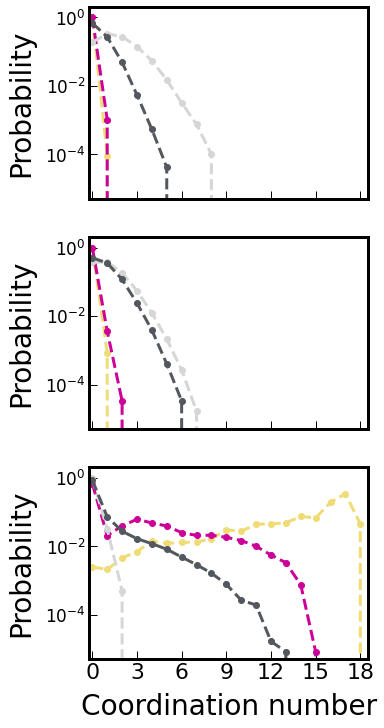

In [11]:
# Plot the contact number distribution:
from matplotlib.ticker import MaxNLocator

gem_list = ['n18q', 'n7q', '15q']
part_list = ['ribosome', 'DNA_all', 'poscrowd', 'negcrowd']
%matplotlib inline
fig, (ax11,ax21,ax31) = plt.subplots(3,1)
eps = [16]
phi = [22]
col = ['#CCCCCC']
contacts = np.arange(0,21)
axes_all = (ax11,ax21,ax31)
y_max = [1, 1, 1]
x_max = [18, 18, 18]

for i in range(0,3):           # ribosome, TC, crowder          ROW
    axis_curr = axes_all[i]
    
    bind_part = gem_list[i]
   
    axis_curr.plot(contacts, nc_dict[(gem_list[i],part_list[0])], '--', linewidth = 3, marker=".",markersize=12,color = '#EFDC76', label = 'Ribosome')
    axis_curr.plot(contacts, nc_dict[(gem_list[i],part_list[1])], '--', linewidth = 3, marker=".",markersize=12, color = '#CC0099', label = 'DNA')
    axis_curr.plot(contacts, nc_dict[(gem_list[i],part_list[2])], '--', linewidth = 3, marker=".",markersize=12,color = '#D6D6D6', label = '(+) crowder')
    axis_curr.plot(contacts, nc_dict[(gem_list[i],part_list[3])], '--', linewidth = 3, marker=".",markersize=12,color = '#53585F', label = '(-) crowder')
    axis_curr.set_xlim(-0.2,x_max[i]+.03*x_max[i])
    axis_curr.xaxis.set_major_locator(MaxNLocator(7,integer=True ))

for ax in fig.get_axes():
    t = ax.yaxis.get_offset_text()
    t.set_size(15)
    t = ax.xaxis.get_offset_text()
    t.set_size(15)
    
    ax.set_ylim(0.000005,2)
    ax.set_yscale('log')
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    
    plt.rcParams["font.family"] = "Nimbus Roman"
    ax.set_ylabel('Probability',size=28,labelpad=10)
    ax.set_xlabel('Coordination number',size=28,labelpad=10)
    ax.tick_params(direction="in",axis='both', which='major',width=1, length=8, labelsize=22)
    ax.tick_params(direction="in", axis='both', which='minor', length=5, labelsize=22)
    
    # Set 3 y-axis ticks with custom labels
    y_min, y_max = ax.get_ylim()
    tick_locations = [1e-4, 1e-2, 1e-0]
    ax.set_yticks(tick_locations)
    ax.set_yticklabels(['$10^{-4}$', '$10^{-2}$', '$10^{0}$'],fontsize=17)
        
for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(5,12)

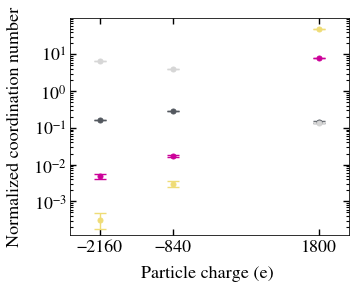

In [14]:
# Plot average coordination number normalized by hard sphere case.
x_plot = np.array([-2160, -840, 1800])

gem_list = ['0q','n7q', 'n18q', '15q']
part_list = ['ribosome', 'DNA_all', 'negcrowd', 'poscrowd']

part_id = part_list[0]
y_plot_rib = np.array([contact_dict[(gem_list[2],part_id)], contact_dict[(gem_list[1],part_id)], contact_dict[(gem_list[3],part_id)]])/contact_dict[(gem_list[0],part_id)]
y_err_rib = np.array([contact_error_dict[(gem_list[2],part_id)], contact_error_dict[(gem_list[1],part_id)], contact_error_dict[(gem_list[3],part_id)]])/contact_dict[(gem_list[0],part_id)]

part_id = part_list[1]
y_plot_dna = np.array([contact_dict[(gem_list[2],part_id)], contact_dict[(gem_list[1],part_id)], contact_dict[(gem_list[3],part_id)]])/contact_dict[(gem_list[0],part_id)]
y_err_dna = np.array([contact_error_dict[(gem_list[2],part_id)], contact_error_dict[(gem_list[1],part_id)], contact_error_dict[(gem_list[3],part_id)]])/contact_dict[(gem_list[0],part_id)]

part_id = part_list[2]
y_plot_negprot = np.array([contact_dict[(gem_list[2],part_id)], contact_dict[(gem_list[1],part_id)], contact_dict[(gem_list[3],part_id)]])/contact_dict[(gem_list[0],part_id)]
y_err_negprot = np.array([contact_error_dict[(gem_list[2],part_id)], contact_error_dict[(gem_list[1],part_id)], contact_error_dict[(gem_list[3],part_id)]])/contact_dict[(gem_list[0],part_id)]

part_id = part_list[3]
y_plot_posprot = np.array([contact_dict[(gem_list[2],part_id)], contact_dict[(gem_list[1],part_id)], contact_dict[(gem_list[3],part_id)]])/contact_dict[(gem_list[0],part_id)]
y_err_posprot = np.array([contact_error_dict[(gem_list[2],part_id)], contact_error_dict[(gem_list[1],part_id)], contact_error_dict[(gem_list[3],part_id)]])/contact_dict[(gem_list[0],part_id)]



fig, ax = plt.subplots(figsize = (5,4))

ax.errorbar(x_plot, y_plot_rib, yerr = y_err_rib.T, marker = '.', markersize = 10, linestyle = '', color='#EFDC76',  capthick = 1.4,   capsize=6, elinewidth=1.4 )
ax.errorbar(x_plot, y_plot_dna, yerr = y_err_dna.T, marker = '.', markersize = 10, linestyle = '', color='#CC0099',  capthick = 1.4,   capsize=6, elinewidth=1.4 )
ax.errorbar(x_plot, y_plot_negprot, yerr = y_err_negprot.T, marker = '.', markersize = 10, linestyle = '', color='#53585F',  capthick = 1.4,   capsize=6, elinewidth=1.4 )
ax.errorbar(x_plot, y_plot_posprot, yerr = y_err_posprot.T, marker = '.', markersize = 10, linestyle = '', color='#D6D6D6',  capthick = 1.4,   capsize=6, elinewidth=1.4 )

ax.set_yscale("log")



ax.set_ylabel('Normalized coordination number',size=18,labelpad=10)
ax.set_xlabel('Particle charge (e) ',size=18,labelpad=10)

ax.set_xticks([-2160, -840, 1800])

ax.tick_params(direction="in",axis='x', which='major', right = True, top = True, width=1.4, length=6, labelsize=18)
ax.tick_params(direction="in",axis='x', which='minor', right = True, top = True, width=1.1, length=3, labelsize=18)
ax.set_xlim(-2700,2340)
ax.set_ylim(0.00012,99)
ax.tick_params(direction="in",axis='y', which='major',  right = True, top = True, width=1.4, length=6, labelsize=18)
ax.tick_params(direction="in",axis='y', which='minor', right = True, top = True, width=1.1, length=3)

from matplotlib import pyplot as plt, ticker as mticker

ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))